# Redes Neuronales

In [245]:
from IPython.display import Image
import torch
import polars as pl
import os
import sys
import numpy as np
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [39]:
device = 'cpu'
sys.path.append('/home/sebacastillo/neuralnets/')
from src.utils import get_project_root
root = get_project_root()

Bib:   
Stevens-Antiga, *Deep Learning with Pytorch*.

Resources:    
https://www.mad.tf.fau.de/files/2019/07/pytorch-cheatsheet-en.pdf 

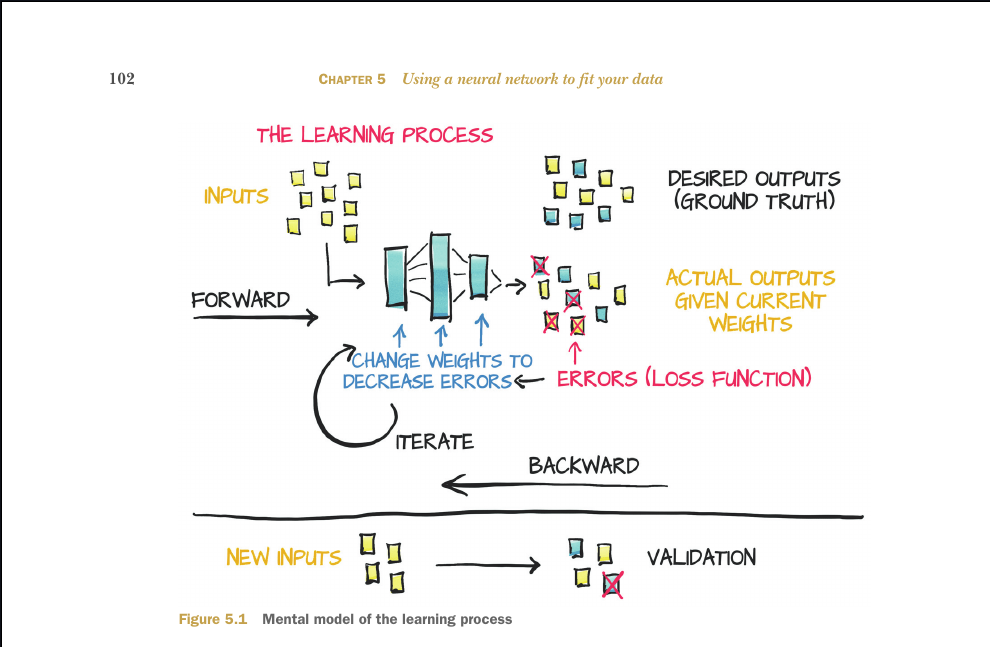

In [3]:

Image('perceptron_learningprocess.png')

Los elementos de una red neuronal simple son:
- capas o 'layers' que constituyen la red (en este caso una sola capa),
- imputs que son los datos de entrada con su correspondiente etiqueta o 'targets'
- la función de pérdida (*loss function*) que permite computar el error del modelo y nos ofrece la señal que se necesita para que la red aprenda,y
- la función de optimización que permite optimizar los párametros del modelo. 

**Ejecicio 1**   

Realice un programa que permita el entrenamiento y prueba de un perceptrón simple con una cantidad variable de entradas. El programa debe proveer las siguientes facilidades:  

-lectura de los patrones de entrenamiento (entradas y salidas) desde un archivo en formato texto separado por comas selección del criterio de finalización del entrenamiento,   
-selección del número máximo de épocas de entrenamiento,   
-selección de la tasa de aprendizaje,   
-prueba del perceptrón entrenado mediante archivos de texto con el mismo formato separado por comas.   

## Exploracion inicial

In [36]:
# Initialize the weights and bias for the perceptron with random values
num_features = 2
weights = torch.randn(num_features, 1, dtype=torch.float32, device=device)
bias = torch.randn(1, dtype=torch.float32, device=device)
print(weights)
print(bias)

tensor([[ 0.3765],
        [-1.3995]])
tensor([0.6243])


In [44]:
# get features columns
features = data[:, :-1]
target = data[:, 2]
print(features)
print(target)

tensor([[-0.9950,  1.0201],
        [ 1.0057,  0.9867],
        [-0.9801, -1.0187],
        ...,
        [ 1.0113,  1.0148],
        [ 1.0105,  0.9782],
        [-0.9996,  1.0440]])
tensor([ 1.,  1., -1.,  ...,  1.,  1.,  1.])


In [38]:
#Compute the forward pass of the perceptron.
linear = torch.add(torch.mm(features, weights), bias)
print(linear)

tensor([[-1.1780],
        [-0.3779],
        [ 1.6809],
        ...,
        [-0.4151],
        [-0.3642],
        [-1.2131]])


In [39]:
# 
linear > 0.

tensor([[False],
        [False],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [40]:
# tensor prediction 
def tensor_pred(cond, t1, t2):
    return (cond * t1) + ((~(cond)) * t2)

In [47]:
predictions  = tensor_pred(linear > 0, 1, -1).float()
print(predictions)

tensor([[-1.],
        [-1.],
        [ 1.],
        ...,
        [-1.],
        [-1.],
        [-1.]])


In [49]:
# backprogation
errors =  target - predictions
print(errors)

tensor([[ 2.,  2.,  0.,  ...,  2.,  2.,  2.],
        [ 2.,  2.,  0.,  ...,  2.,  2.,  2.],
        [ 0.,  0., -2.,  ...,  0.,  0.,  0.],
        ...,
        [ 2.,  2.,  0.,  ...,  2.,  2.,  2.],
        [ 2.,  2.,  0.,  ...,  2.,  2.,  2.],
        [ 2.,  2.,  0.,  ...,  2.,  2.,  2.]])


Creo que el encoding de taget debería ser tipo one-hot, no 1/-1.

In [ ]:
# transform target to one-hot
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
# 

# Acceso a Datos 'XOR.csv'

In [272]:
device = 'cpu'
sys.path.append('/home/sebacastillo/neuralnets/')
from src.utils import get_project_root
root = get_project_root()

In [474]:
data = pl.read_csv(str(root) + '/data/XOR.csv')
X = data[:, :-1]
y = data[:, 2]
X = X.to_numpy()
y = y.to_numpy()

# one-hot encoding of target
y = np.where(y > 0, 1, 0)

print(f'X: {X}')
print(f'y: {y}')

X: [[ 1.0325  -1.0188 ]
 [ 1.0261   1.0343 ]
 [ 0.98587  0.97163]
 ...
 [ 1.0028  -1.0206 ]
 [-0.99927 -1.0024 ]
 [-1.0049   1.0015 ]]
y: [1 0 0 ... 1 0 1]


In [472]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=26)

In [473]:
len(X_train), len(X_test)

(1473, 726)

## Seteo Parametros de la NN

In [475]:
batch_size = 64
input_dim = 2
hidden_dim = 10
output_dim = 1

## Data Class

In [476]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len
   
# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64])


# Diseño 2Layers NN

In [477]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        self.layer_2 = nn.Linear(hidden_dim, output_dim)
       
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = torch.nn.functional.sigmoid(self.layer_2(x))

        return x
       
model = NeuralNetwork(input_dim, hidden_dim, output_dim)

# imprimo  del modelo
print(f"Model structure: {model}\n\n")
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)


Layer: layer_1.weight | Size: torch.Size([10, 2]) | Values : tensor([[ 0.7226, -0.7251],
        [-1.5519,  0.1900]], grad_fn=<SliceBackward0>) 

Layer: layer_1.bias | Size: torch.Size([10]) | Values : tensor([-0.4344, -0.6595], grad_fn=<SliceBackward0>) 

Layer: layer_2.weight | Size: torch.Size([1, 10]) | Values : tensor([[-0.2555,  0.1710, -0.0237,  0.2796,  0.2123, -0.1993,  0.0686,  0.1982,
         -0.1062, -0.0129]], grad_fn=<SliceBackward0>) 

Layer: layer_2.bias | Size: torch.Size([1]) | Values : tensor([0.0390], grad_fn=<SliceBackward0>) 



Optimización y Función de Pérdida

Posibles funciones de perdida:   

- [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (Mean Square Error) para regresion,    
- [nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) (Negative Log Likelihood) para clasificación,   
- [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) combina ``nn.LogSoftmax`` and ``nn.NLLLoss``.   
- [nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) Binary Cross-Entropy Loss.    

En el caso de nuestro Perceptron vamos a pasar nuestro logit por  ``nn.CrossEntropyLoss``, que los normaliza y calcula el error de nuestras predicciones.

Seteo Parametros de la Optimización

In [478]:
train_dataloader = 0.1  # too small: 1e-3; 1e-2
# Initialize the loss function
loss_fn = nn.BCELoss()
#loss_fn = nn.CrossEntropyLoss()
num_epochs = 10

In [479]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Entreno la Red y Grafico 

In [480]:
loss_values = []
size = len(train_dataloader.dataset)  # Define size as the length of the dataset

# The simplest way to build a training loop is to use two nested for-loops, one for epochs and one for batches:
for epoch in range(num_epochs):
    for batch, (X, y) in enumerate(train_dataloader):  # Enumerate over train_dataloader to get the batch index
        # zero the parameter gradients
        optimizer.zero_grad()       
        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    # Print intermediate step
    print(f'Epoca: {epoch}, loss: {loss}')
print(f'Epoca: {num_epochs} Entrenamiento Completo')

Epoca: 0, loss: 0.18244239687919617
Epoca: 1, loss: 0.09687836468219757
Epoca: 2, loss: 0.058874618262052536
Epoca: 3, loss: 0.10807397961616516
Epoca: 4, loss: 0.027460617944598198
Epoca: 5, loss: 0.052255600690841675
Epoca: 6, loss: 0.07065651565790176
Epoca: 7, loss: 0.038125067949295044
Epoca: 8, loss: 0.3213578164577484
Epoca: 9, loss: 0.010054769925773144
Epoca: 10 Entrenamiento Completo


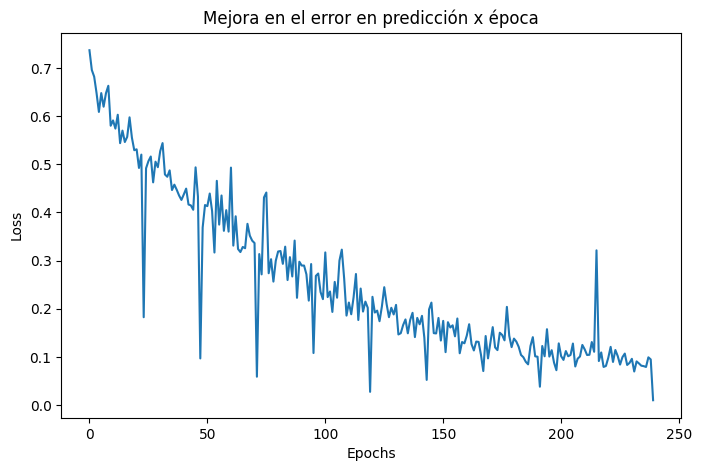

In [481]:
#step = np.linspace(0, 100, 240)
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(np.array(loss_values))
plt.title("Mejora en el error en predicción x época")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Evalución

### Accuracy

In [482]:
with torch.no_grad():
    y_pred = []  # Initialize y_pred list
    y_test = []  # Initialize y_test list
    total = 0
    correct = 0
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum().item()        
print(f'Accuracy of the network: {100 * correct // total}%')


Accuracy of the network: 100%


## Precision - Recall (Exactitud-Exhaustividad)

In [483]:
y_pred = list(itertools.chain(*y_pred))
y_test = list(itertools.chain(*y_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       366
         1.0       1.00      1.00      1.00       360

    accuracy                           1.00       726
   macro avg       1.00      1.00      1.00       726
weighted avg       1.00      1.00      1.00       726



## Matrix-Plot

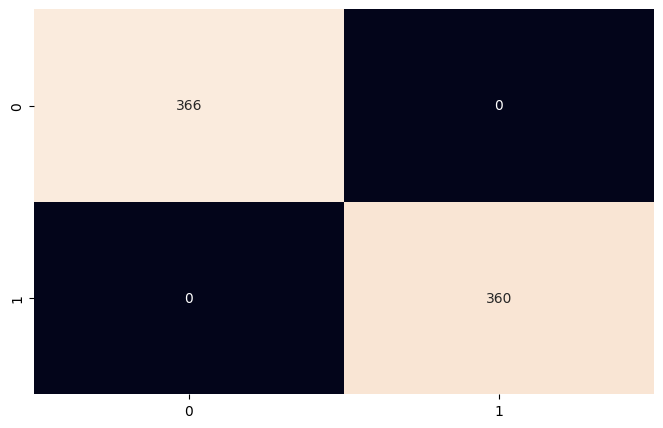

In [484]:
cf_matrix = confusion_matrix(y_test, y_pred)
plt.subplots(figsize=(8, 5))
sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")
plt.show()

# Acceso a Datos 'OR.csv'

In [578]:
data = pl.read_csv(str(root) + '/data/OR.csv')
X = data[:, :-1]
y = data[:, 2]
X = X.to_numpy()
y = y.to_numpy()

# one-hot encoding of target
y = np.where(y > 0, 1, 0)

print(f'X: {X}')
print(f'y: {y}')


X: [[-0.99501  1.0201 ]
 [ 1.0057   0.98668]
 [-0.9801  -1.0187 ]
 ...
 [ 1.0113   1.0148 ]
 [ 1.0105   0.9782 ]
 [-0.99957  1.044  ]]
y: [1 1 0 ... 1 1 1]


In [579]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=26)

In [580]:
len(X_train),len(y_train), len(X_test), len(y_test)

(1759, 1759, 440, 440)

Seteo Parametros de la NN

In [581]:
batch_size = 120
input_dim = 2
output_dim = 1

Data Class

In [582]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len
   
# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([120, 2])
y shape: torch.Size([120])


# Diseño Perceptron 1º + Train-Test_Split

In [583]:
# Define the model
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(2, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc(x))
        return x

# set model      
model_perceptron = Perceptron()

# imprimo del modelo
print(f"Model structure: {model_perceptron}\n\n")
for name, param in model_perceptron.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: Perceptron(
  (fc): Linear(in_features=2, out_features=1, bias=True)
)


Layer: fc.weight | Size: torch.Size([1, 2]) | Values : tensor([[-0.5989,  0.3924]], grad_fn=<SliceBackward0>) 

Layer: fc.bias | Size: torch.Size([1]) | Values : tensor([-0.4440], grad_fn=<SliceBackward0>) 



Seteo Parametros de la Optimización

In [584]:
learning_rate = 0.1  # too small: 1e-3; 1e-2
# Initialize the loss function
loss_fn = nn.BCELoss() #Binary Cross-Entropy Loss
#loss_fn = nn.CrossEntropyLoss()
num_epochs = 1000

In [585]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Entreno la Red y Grafico 

In [586]:
loss_values = []
size = len(train_dataloader.dataset)  # Define size as the length of the dataset

for epoch in range(num_epochs):
    for batch, (X, y) in enumerate(train_dataloader):  # Enumerate over train_dataloader to get the batch index
        # zero the parameter gradients
        optimizer.zero_grad()       
        # forward + backward + optimize
        pred = model_perceptron(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    # Print intermediate step
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")    
print(f'Epoca: {num_epochs} Entrenamiento Completo')

Epoch: 0, Loss: 0.928914487361908
Epoch: 100, Loss: 0.9697383642196655
Epoch: 200, Loss: 0.9777306914329529
Epoch: 300, Loss: 0.9934151768684387
Epoch: 400, Loss: 0.9078047275543213
Epoch: 500, Loss: 0.8728575706481934
Epoch: 600, Loss: 0.9495022892951965
Epoch: 700, Loss: 0.8809023499488831
Epoch: 800, Loss: 0.9576235413551331
Epoch: 900, Loss: 0.8551003932952881
Epoca: 1000 Entrenamiento Completo


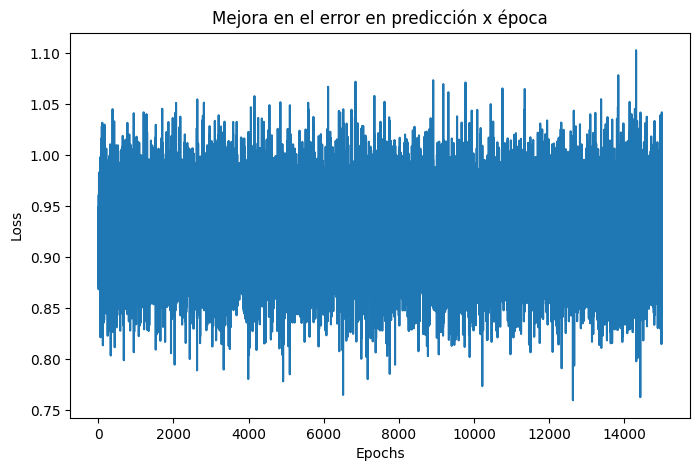

In [587]:
#step = np.linspace(0, 100, 240)
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(np.array(loss_values))
plt.title("Mejora en el error en predicción x época")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Accuracy

In [588]:
with torch.no_grad():
    y_pred = []  # Initialize y_pred list
    y_test = []  # Initialize y_test list
    total = 0
    correct = 0
    for X, y in test_dataloader:
        outputs = model_perceptron(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum().item()        
print(f'Accuracy of the network: {100 * correct // total}%')


Accuracy of the network: 50%


Conclusion: Desastroso

# Diseño Perceptron 2º sin TTsplit

In [608]:
OR_problem = True

In [609]:
if OR_problem:
   data = pl.read_csv(str(root) + '/data/OR.csv')
else:
   data = pl.read_csv(str(root) + '/data/XOR.csv')

In [610]:
X = data[:, :-1]
y = data[:, 2]
X = X.to_numpy()
y = y.to_numpy()

# one-hot encoding of target
y = np.where(y > 0, 1, 0)

print(f'X: {X}')
print(f'y: {y}')


X: [[-0.99501  1.0201 ]
 [ 1.0057   0.98668]
 [-0.9801  -1.0187 ]
 ...
 [ 1.0113   1.0148 ]
 [ 1.0105   0.9782 ]
 [-0.99957  1.044  ]]
y: [1 1 0 ... 1 1 1]


In [611]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

# param
learning_rate = 0.1
n_epoch = 1000

# Prepare input and output tensors
inputs = torch.tensor(X, dtype=torch.float32)
labels = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define the model
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(2, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc(x))
        return x

model = Perceptron()

# Loss function and optimizer
loss_function = nn.BCELoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# prueba hecha con optim.Adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# loss
loss_values = []

# Training loop
for epoch in range(n_epoch):
    # Forward pass
    outputs = model(inputs)
    loss = loss_function(outputs, labels)
    loss_values.append(loss.item())
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

# Testing the model
with torch.no_grad():
    test_outputs = model(inputs)
    test_outputs = (test_outputs > 0.5).float()
    accuracy = (test_outputs == labels).float().mean()
    print(f"Accuracy: {accuracy.item()}")


Epoch: 0, Loss: 0.8520609140396118
Epoch: 100, Loss: 0.02250201813876629
Epoch: 200, Loss: 0.009144808165729046
Epoch: 300, Loss: 0.005181922577321529
Epoch: 400, Loss: 0.00340983085334301
Epoch: 500, Loss: 0.002443893812596798
Epoch: 600, Loss: 0.0018512369133532047
Epoch: 700, Loss: 0.001457676524296403
Epoch: 800, Loss: 0.0011810961877927184
Epoch: 900, Loss: 0.0009782640263438225
Accuracy: 1.0


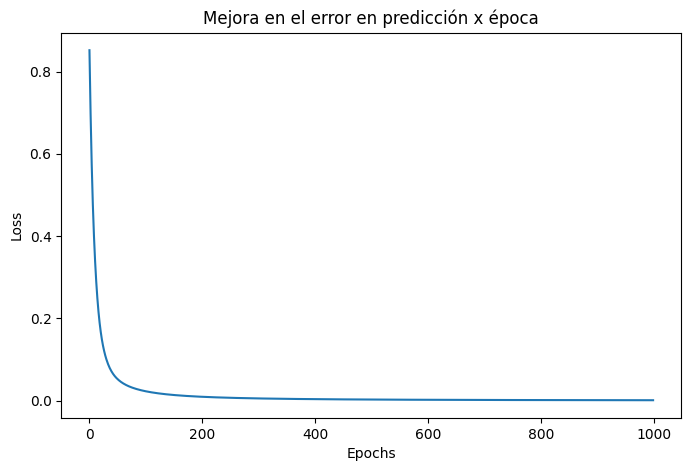

In [612]:
#step = np.linspace(0, 100, 240)
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(np.array(loss_values))
plt.title("Mejora en el error en predicción x época")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Diseño Respuesta Ejercicio 1

In [709]:
# Params
OR_problem = True
split = 0.3
learning_rate = 0.1
n_epoch = 100

In [710]:
if OR_problem:
   data = pl.read_csv(str(root) + '/data/OR.csv')
else:
   data = pl.read_csv(str(root) + '/data/XOR.csv')

In [711]:
len(data)

2199

In [712]:
X = data[:, :-1]
y = data[:, 2]
X = X.to_numpy()
y = y.to_numpy()
# one-hot encoding of target
y = np.where(y > 0, 1, 0)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=26)

In [713]:
print(f'X: {X_train}')
print(f'y: {y_train}')

X: [[-1.009    0.97974]
 [-1.014   -0.9809 ]
 [ 0.98688  0.95687]
 ...
 [-1.0045  -1.     ]
 [ 0.9996   1.     ]
 [-1.0012   0.9694 ]]
y: [1 0 1 ... 0 1 1]


In [714]:
# Prepare input and output tensors
inputs_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
inputs_test = torch.tensor(X_test, dtype=torch.float32)
labels_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the model
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(2, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc(x))
        return x

model = Perceptron()

# Loss function and optimizer
loss_function = nn.BCELoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# prueba hecha con optim.Adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# loss
loss_values = []

# Training loop
for epoch in range(n_epoch):
    # Forward pass
    outputs = model(inputs_train)
    loss = loss_function(outputs, labels_train)
    loss_values.append(loss.item())    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

# Testing the model
with torch.no_grad():
    test_outputs = model(inputs_test)
    test_outputs = (test_outputs > 0.5).float()
    accuracy = (test_outputs == labels_test).float().mean()
    print(f"Accuracy: {accuracy.item()}")


Epoch: 0, Loss: 0.7577171325683594
Epoch: 10, Loss: 0.321990430355072
Epoch: 20, Loss: 0.1604151576757431
Epoch: 30, Loss: 0.09311284124851227
Epoch: 40, Loss: 0.06248985603451729
Epoch: 50, Loss: 0.04649067297577858
Epoch: 60, Loss: 0.03685859963297844
Epoch: 70, Loss: 0.030444616451859474
Epoch: 80, Loss: 0.02584095299243927
Epoch: 90, Loss: 0.022357886657118797
Accuracy: 1.0


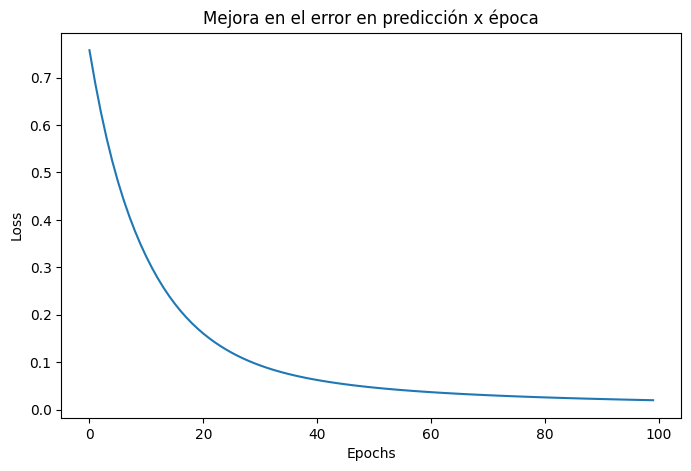

In [715]:
#step = np.linspace(0, 100, 240)
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(np.array(loss_values))
plt.title("Mejora en el error en predicción x época")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Graficar: Guardar los pesos de los primeros 10 weight en el entrenamiento.
Criterio de corte: mejora el aprendizaje luego de 5 iteraciones?

# Perceptron en python pelado

In [1458]:
df = np.loadtxt(str(root) + '/data/XOR.csv',
                 delimiter=",")
print(df)

[[-1.0291   0.97256  1.     ]
 [ 1.0325  -1.0188   1.     ]
 [ 1.0261   1.0343  -1.     ]
 ...
 [ 1.0028  -1.0206   1.     ]
 [-0.99927 -1.0024  -1.     ]
 [-1.0049   1.0015   1.     ]]


In [1459]:
np.random.shuffle(df)
print(df)

[[-0.95309  0.98865  1.     ]
 [ 1.0067  -1.0456   1.     ]
 [ 0.98945  0.99441 -1.     ]
 ...
 [-0.99243 -1.0005  -1.     ]
 [-0.99903 -0.97037 -1.     ]
 [ 0.99989 -1.0263   1.     ]]


Particionar los datos

In [1460]:
def ttsplit(data, prop=0.2):
    assert isinstance(data, np.ndarray), "Input should be a NumPy array"
    p = int(len(data) * prop)
    test = data[:p, :]
    train = data[p:, :]
    X_train = train[:,:-1]
    y_train = train[:,-1]
    X_test = test[:,:-1]
    y_test = test[:,-1]
    return X_train, y_train, X_test, y_test

In [1461]:
X_train, y_train, X_test, y_test = ttsplit(df, 0.2)

Funciones para usar en la clase perceptron

In [1462]:
'''
# params
learning_rate = 0.1
epoch = 10
iterat = 5
predicted_example = -1
target_example = 1
# training
num_features = np.prod(X_train.shape[1:])
data_reshaped = X_train.reshape(-1,2)
labels = y_train
weights = np.zeros(1 + num_features)
update =  learning_rate * (target_example - predicted_example)
x1 = X_train[0]
# Update the feature weights with the calculated update
weights[1:] += update * x1
# Update the bias term with the calculated update
weights[0] += update
# Increment the error count if the update is not equal to zero,
# which means there was a misclassification
errors = int(update != 0.0)
# Compute the weighted sum of the input features (also known as z-value)
# by taking the dot product of the input data and the feature weights (self.tetha[1:]),
# then adding the bias term (self.tetha[0])
z = np.dot(x1, weights[1:]) + weights[0]
prediction = np.where(z >= 0.0, 1, -1)

# print all steps
print(f'features: {num_features}')
print(f'reshaped: {data_reshaped}')
print(f'labels: {labels}')
print(f'weight initialize: {weights}')
for i in range(3):
    print(f'forloop: {i}')
print(f'update: {update}')
print(f'X1: {x1}')
print(f'weight features: {weights}')
print(f'weight bias: {weights}')
print(f'errors: {errors}')
print(f'z_value: {z}')
print(f'prediccion: {prediction}')
'''

"\n# params\nlearning_rate = 0.1\nepoch = 10\niterat = 5\npredicted_example = -1\ntarget_example = 1\n# training\nnum_features = np.prod(X_train.shape[1:])\ndata_reshaped = X_train.reshape(-1,2)\nlabels = y_train\nweights = np.zeros(1 + num_features)\nupdate =  learning_rate * (target_example - predicted_example)\nx1 = X_train[0]\n# Update the feature weights with the calculated update\nweights[1:] += update * x1\n# Update the bias term with the calculated update\nweights[0] += update\n# Increment the error count if the update is not equal to zero,\n# which means there was a misclassification\nerrors = int(update != 0.0)\n# Compute the weighted sum of the input features (also known as z-value)\n# by taking the dot product of the input data and the feature weights (self.tetha[1:]),\n# then adding the bias term (self.tetha[0])\nz = np.dot(x1, weights[1:]) + weights[0]\nprediction = np.where(z >= 0.0, 1, -1)\n\n# print all steps\nprint(f'features: {num_features}')\nprint(f'reshaped: {data

In [1463]:
'''
import numpy as np

class Perceptron:

    def __init__(self, learning_rate, epoch):
        self.learning_rate = learning_rate
        self.epoch = epoch

    def training(self, data, labels):  
        
        self.weight = np.zeros(1 + data.shape[1])
        # Initialize an empty list to store the number of misclassifications (errors)
        # during each iteration of the training process
        self.errors_ = []
        self.weights_ = []  # Store weights at each iteration

        # Iterate over the specified number of training iterations
        for _ in range(self.epoch):
            # Initialize the error count for the current iteration
            errors = 0
            
            # Iterate over each sample (xi) and its corresponding label (target)
            # in the reshaped input data and labels
            for xi, target in zip(data, labels):
                # Calculate the update for the weights based on the difference
                # between the target label and the predicted label, scaled by the learning rate
                update = self.learning_rate * (target - self.predict(xi))
                
                # Update the feature weights with the calculated update
                self.weight[1:] += update * xi
                
                # Update the bias term with the calculated update
                self.weight[0] += update
                
                # Increment the error count if the update is not equal to zero,
                # which means there was a misclassification
                errors += int(update != 0.0)
            
            # Append the total number of errors for the current iteration to the errors list
            self.errors_.append(errors)
            self.weights_.append(self.weight.copy())  # Store the current weights

        # Return the perceptron object itself, allowing method chaining
        return self

    def predict(self, data):                
        # Calculate the weighted sum of the input features (also known as z-value)
        # for each sample in the reshaped data, then apply the activation function
        # If the z-value is greater than or equal to 0, the output is 1, otherwise, it's -1
        prediction = np.where(self.calculation_valor_z(data) >= 0.0, 1, -1)
        
        # Return the predicted class labels (1 or -1) for the input data
        return prediction

    def calculation_valor_z(self, data):
        # Compute the weighted sum of the input features (also known as z-value)
        # by taking the dot product of the input data and the feature weights (self.weight[1:]),
        # then adding the bias term (self.weight[0])
        z = np.dot(data, self.weight[1:]) + self.weight[0]
        return z    
'''  

"\nimport numpy as np\n\nclass Perceptron:\n\n    def __init__(self, learning_rate, epoch):\n        self.learning_rate = learning_rate\n        self.epoch = epoch\n\n    def training(self, data, labels):  \n        \n        self.weight = np.zeros(1 + data.shape[1])\n        # Initialize an empty list to store the number of misclassifications (errors)\n        # during each iteration of the training process\n        self.errors_ = []\n        self.weights_ = []  # Store weights at each iteration\n\n        # Iterate over the specified number of training iterations\n        for _ in range(self.epoch):\n            # Initialize the error count for the current iteration\n            errors = 0\n            \n            # Iterate over each sample (xi) and its corresponding label (target)\n            # in the reshaped input data and labels\n            for xi, target in zip(data, labels):\n                # Calculate the update for the weights based on the difference\n                # b

Clase Perceptron

In [1464]:
import numpy as np

class Perceptron:

    def __init__(self, learning_rate, epoch):
        self.learning_rate = learning_rate
        self.epoch = epoch

    def training(self, data, labels):  
        self.weight = np.zeros(1 + data.shape[1])    
        self.errors_ = []
        self.weights_ = []  # Store weights at each iteration

        # Iterate over the specified number of training iterations
        for _ in range(self.epoch):            
            errors = 0
            for xi, target in zip(data, labels):
                update = self.learning_rate * (target - self.predict(xi))                
                self.weight[1:] += update * xi
                self.weight[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
            self.weights_.append(self.weight.copy())  # Store the current weights        
        return self

    def predict(self, data):                
        prediction = np.where(self.calculation_valor_z(data) >= 0.0, 1, -1)
        return prediction

    def calculation_valor_z(self, data):
        z = np.dot(data, self.weight[1:]) - self.weight[0]
        return z    

In [1465]:
#initialize perceptron
model = Perceptron(learning_rate=0.1, epoch=100)
#training perceptron
model = model.training(X_train,y_train)

In [1466]:
print(" weights:", model.weight)
print("Errors during training:", model.errors_)
print("Weights at each iteration:", model.weights_)
new_data = np.array([[1.0, 2.0], [-1.0, -2.0]])
predictions = model.predict(new_data)
print("Predicted class labels for new data points:", predictions)

 weights: [ 0.2       0.190216 -0.17799 ]
Errors during training: [763, 752, 756, 760, 764, 764, 754, 762, 752, 756, 764, 760, 760, 764, 762, 766, 772, 768, 772, 776, 770, 748, 766, 772, 774, 758, 770, 746, 760, 752, 760, 768, 756, 760, 756, 764, 760, 760, 760, 768, 780, 772, 768, 760, 748, 748, 764, 756, 764, 752, 748, 760, 760, 768, 748, 764, 756, 768, 756, 764, 744, 764, 780, 772, 758, 766, 774, 762, 748, 758, 762, 774, 754, 764, 768, 764, 764, 764, 756, 764, 764, 752, 764, 752, 752, 752, 752, 756, 764, 756, 752, 764, 762, 746, 770, 766, 774, 764, 762, 758]
Weights at each iteration: [array([0.2     , 0.148546, 0.208922]), array([0.2     , 0.131956, 0.190668]), array([0.2     , 0.127958, 0.189578]), array([0.2     , 0.12655 , 0.181034]), array([0.2     , 0.124566, 0.17909 ]), array([0.2     , 0.126536, 0.18427 ]), array([ 0.2     ,  0.190144, -0.177976]), array([0.2     , 0.150728, 0.198748]), array([0.2     , 0.131716, 0.194978]), array([0.2     , 0.117502, 0.171942]), array([0.2  

In [1467]:
error_rates = []
for i in (model.errors_):
    error_rates.append(i/len(X_train))


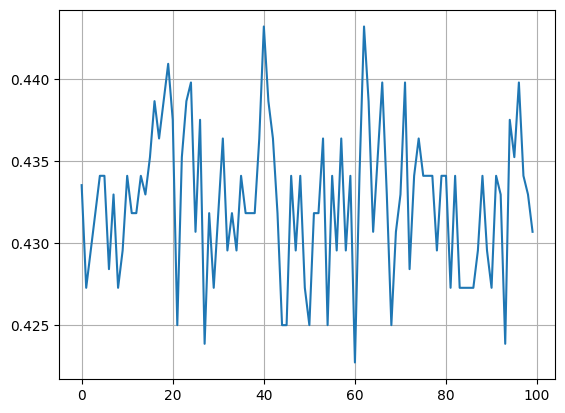

In [1468]:
plt.plot(error_rates)
plt.grid(True)
plt.show()

In [1469]:
def accuracy(true_labels, predicted_labels):
    correct_predictions = np.sum(true_labels == predicted_labels)
    total_predictions = len(true_labels)
    return (correct_predictions / total_predictions) * 100

# Generate predictions for the training data
predicted_labels = model.predict(X_test)

# Calculate the accuracy
model_accuracy = accuracy(y_test, predicted_labels)
print(f"Perceptron model accuracy: {model_accuracy:.2f}%")

Perceptron model accuracy: 27.27%


In [1470]:
def plot_decision_boundary(X, y, weight):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    x_values = np.linspace(x_min, x_max, 100)
    y_values = - (weight[0] + weight[1] * x_values) / weight[2]

    plt.plot(x_values, y_values, label=f"Iteration {_+1}")

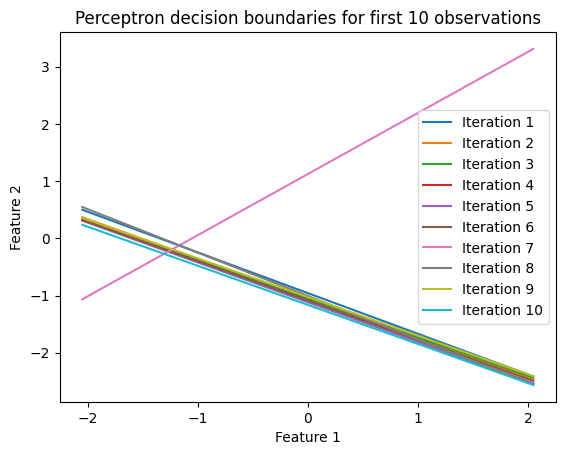

In [1471]:
for _ in range(10):
    plot_decision_boundary(X_train, y_train, model.weights_[_])
    # Plot the data points
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.title('Perceptron decision boundaries for first 10 observations')
plt.show()
